# 1. Choose a dataset (TF datasets or some of your own choice, NOT Keras datasets).

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import Dense, Input, GlobalAveragePooling2D, BatchNormalization, Dropout
from keras.layers.merge import concatenate

In [2]:
tfds.list_builders()

['abstract_reasoning',
 'accentdb',
 'aeslc',
 'aflw2k3d',
 'ag_news_subset',
 'ai2_arc',
 'ai2_arc_with_ir',
 'amazon_us_reviews',
 'anli',
 'arc',
 'bair_robot_pushing_small',
 'bccd',
 'beans',
 'big_patent',
 'bigearthnet',
 'billsum',
 'binarized_mnist',
 'binary_alpha_digits',
 'blimp',
 'bool_q',
 'c4',
 'caltech101',
 'caltech_birds2010',
 'caltech_birds2011',
 'cars196',
 'cassava',
 'cats_vs_dogs',
 'celeb_a',
 'celeb_a_hq',
 'cfq',
 'cherry_blossoms',
 'chexpert',
 'cifar10',
 'cifar100',
 'cifar10_1',
 'cifar10_corrupted',
 'citrus_leaves',
 'cityscapes',
 'civil_comments',
 'clevr',
 'clic',
 'clinc_oos',
 'cmaterdb',
 'cnn_dailymail',
 'coco',
 'coco_captions',
 'coil100',
 'colorectal_histology',
 'colorectal_histology_large',
 'common_voice',
 'coqa',
 'cos_e',
 'cosmos_qa',
 'covid19',
 'covid19sum',
 'crema_d',
 'curated_breast_imaging_ddsm',
 'cycle_gan',
 'd4rl_adroit_door',
 'd4rl_adroit_hammer',
 'd4rl_adroit_pen',
 'd4rl_adroit_relocate',
 'd4rl_mujoco_ant',
 'd4

In [3]:
(test_ds, validate_ds, train_ds), metadata = tfds.load(
'malaria',
split=['train[:15%]', 'train[15%:30%]', 'train[30%:100%]'],
with_info=True,
as_supervised=True)
print(len(test_ds))
print(len(validate_ds))
print(len(train_ds))

Dl Completed...: 0 url [00:00, ? url/s]
Dl Completed...: 100%|██████████| 1/1 [00:00<00:00, 81.94 url/s]
Extraction completed...: 0 file [00:00, ? file/s]
Dl Completed...: 100%|██████████| 1/1 [00:00<00:00, 61.45 url/s]


Dataset malaria downloaded and prepared to /home/oskari/tensorflow_datasets/malaria/1.0.0. Subsequent calls will reuse this data.
4134
4133
19291


# 2. Choose a CNN model. Use a pretrained model from TF Hub or Keras applications (or some other, should you find one). I'd recommend EfficientNet (B0 or B1), but feel free to choose.

In [19]:
# Create the base model from the pre-trained model EfficientNet B1
base_model = tf.keras.applications.MobileNetV3Small(
    input_shape=(224,224,3), 
    alpha=1.0, 
    minimalistic=True, 
    include_top=False,
    weights='imagenet', 
    classes=2, 
    pooling="avg",
    dropout_rate=0.2, 
    include_preprocessing=False
)

# 3. Implement preprocessing. Your model may work only on images of a certain size, so crop and rescale if needed. Be sure to use the preprocessing operation that comes with the model package - some map pixels to [0,1] and some to [-1,1].


In [50]:
BATCH_SIZE = 128
IMAGE_SIZE = [224, 224]


(train_ds, val_ds, test_ds), metadata = tfds.load(
    'malaria',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

# 4. Build an input pipeline. Preprocessing should be a part of it. Minibatches should fit into GPU memory.

tf.keras.applications.efficientnet.preprocess_input does nothing. not required. so input pipeline and preprocessing are already part of base model.

# 5. Load only the convolutional base of the pre-trained model and build your own decision part on top of that (e.g. two dense layers + softmax). Sometimes a global averaging of the base model output is needed (some architectures do it as their last step, some don't).

In [34]:
# decision part
def create_decision():
  # create model
  x = base_model.output
  x = BatchNormalization()(x)
  x = Dense(1024, activation='relu', kernel_regularizer='l2')(x)
  x = Dense(1024, activation='relu', kernel_regularizer='l2')(x)
  x = Dropout(0.1)(x)
  predictions = Dense(1, activation='sigmoid')(x)
  return x, predictions

In [35]:
# create the model

x, predictions = create_decision()
model = Model(inputs=base_model.input, outputs=predictions)

In [ ]:
# print(model.summary())

In [36]:
# freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# model.compile(optimizer='adam', loss='binary_crossentropy')
# print(model.trainable_variables)

# 6. Implement data augmentation. Use the augmentation layers (build own custom ones if you like) and add them between the input layer and the pre-trained model (use the functional API)

In [51]:
from tensorflow.keras.layers import RandomFlip, RandomRotation, Resizing, Rescaling

data_augmentation = tf.keras.Sequential([
  RandomFlip("horizontal_and_vertical"),
  RandomRotation(1, fill_mode="constant"),
])

IMG_SIZE = 224

resize_and_rescale = tf.keras.Sequential([
  Resizing(IMG_SIZE, IMG_SIZE),
  Rescaling(1./255)
])

batch_size = 128
AUTOTUNE = tf.data.AUTOTUNE

def prepare(ds, shuffle=False, augment=False):

  # Resize and rescale all datasets.
  ds = ds.map(lambda x, y: (resize_and_rescale(x), y), 
              num_parallel_calls=AUTOTUNE)

  if shuffle:
    ds = ds.shuffle(1000)

  # Batch all datasets.
  ds = ds.batch(batch_size)

  # Use data augmentation only on the training set.
  if augment:
    ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                num_parallel_calls=AUTOTUNE)

  # Use buffered prefetching on all datasets.
  return ds.prefetch(buffer_size=AUTOTUNE)

# Show some cool examples of cells

In [52]:
get_label_name = metadata.features['label'].int2str

image_iterable = iter(train_ds)

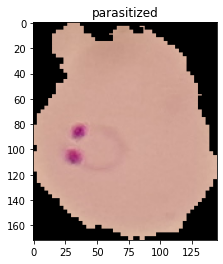

In [63]:
# rerun this cell to get other images

image, label = next(image_iterable)
_ = plt.imshow(image)
_ = plt.title(get_label_name(label))

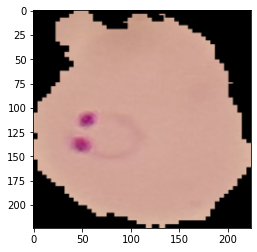

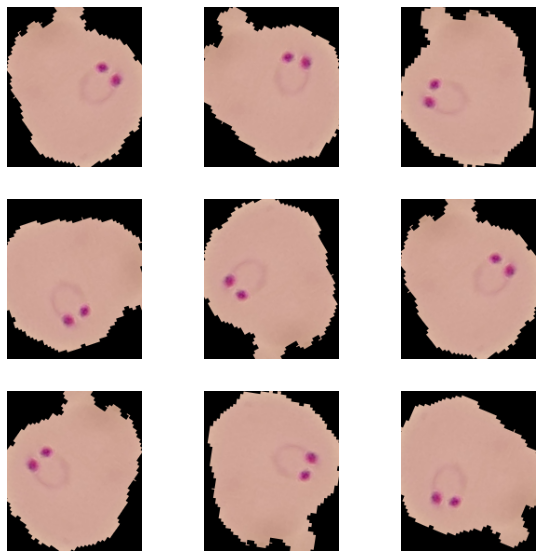

In [64]:
result = resize_and_rescale(image)
_ = plt.imshow(result)

# Add the image to a batch.
image = tf.expand_dims(image, 0)

plt.figure(figsize=(10, 10))
for i in range(9):
  augmented_image = data_augmentation(image)
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(augmented_image[0])
  plt.axis("off")

In [65]:
train_ds = prepare(train_ds, shuffle=True, augment=True)
val_ds = prepare(val_ds)
test_ds = prepare(test_ds)

In [ ]:
print(train_ds)

<PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>


In [17]:
# tf.keras.utils.plot_model(model, show_shapes=True, expand_nested=True)

In [40]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=tf.keras.metrics.BinaryAccuracy())

In [41]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv (Conv2D)                  (None, 112, 112, 16  432         ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 Conv/BatchNorm (BatchNormaliza  (None, 112, 112, 16  64         ['Conv[0][0]']                   
 tion)                          )                                                           

# 7. Establish a baseline: train and validate your model (with an optimizer of your choice). Plot loss and accuracy curves.

In [42]:
checkpoint_path = "models/transfer-net.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True), cp_callback]

In [43]:
history = model.fit(train_ds,
          validation_data=val_ds,
          epochs=30,
          verbose='auto',
          callbacks=callbacks)

Epoch 1/30
172/173 [============================>.] - ETA: 0s - loss: 2.8349 - binary_accuracy: 0.9208
Epoch 00001: saving model to models/transfer-net.ckpt
173/173 [==============================] - 38s 211ms/step - loss: 2.8314 - binary_accuracy: 0.9208 - val_loss: 0.2741 - val_binary_accuracy: 0.9441
Epoch 2/30
172/173 [============================>.] - ETA: 0s - loss: 0.2496 - binary_accuracy: 0.9368
Epoch 00002: saving model to models/transfer-net.ckpt
173/173 [==============================] - 38s 212ms/step - loss: 0.2498 - binary_accuracy: 0.9366 - val_loss: 0.2373 - val_binary_accuracy: 0.9459
Epoch 3/30
172/173 [============================>.] - ETA: 0s - loss: 0.2430 - binary_accuracy: 0.9395
Epoch 00003: saving model to models/transfer-net.ckpt
173/173 [==============================] - 38s 214ms/step - loss: 0.2428 - binary_accuracy: 0.9395 - val_loss: 0.2373 - val_binary_accuracy: 0.9438
Epoch 4/30
172/173 [============================>.] - ETA: 0s - loss: 0.2265 - binary

In [47]:
model.evaluate(val_ds)

22/22 [==============================] - 3s 143ms/step - loss: 0.1662 - binary_accuracy: 0.9496


[0.16622962057590485, 0.9495645761489868]

# Plot history

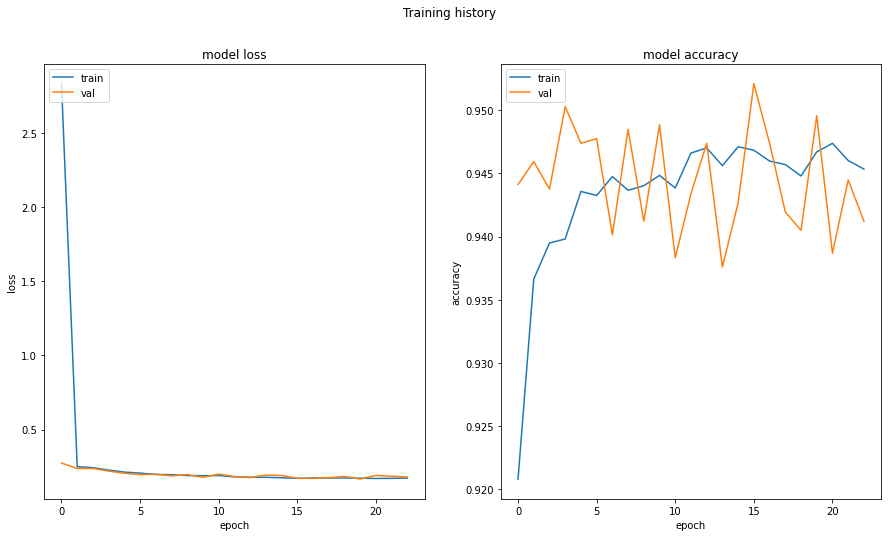

In [46]:
def plot_training_metrics(history):

  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,8))
  fig.suptitle('Training history')

  ax1.plot(history.history['loss'])
  ax1.plot(history.history['val_loss'])
  ax1.set_title('model loss')
  ax1.set_ylabel('loss')
  ax1.set_xlabel('epoch')
  ax1.legend(['train', 'val'], loc='upper left')

  ax2.plot(history.history['binary_accuracy'])
  ax2.plot(history.history['val_binary_accuracy'])
  ax2.set_title('model accuracy')
  ax2.set_ylabel('accuracy')
  ax2.set_xlabel('epoch')
  ax2.legend(['train', 'val'], loc='upper left')

  plt.show()

plot_training_metrics(history)

# Fine-tuning the model

Fine-tune the model (trained at 7) by opening a few layers (or layer blocks if it's more natural in the model architecture) at a time. Train with a very small learning rate (might take a few tries to find a good starting value). Repeat opening layers until there's no improvement.

In [66]:
print(model.summary())

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv (Conv2D)                  (None, 112, 112, 16  432         ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 Conv/BatchNorm (BatchNormaliza  (None, 112, 112, 16  64         ['Conv[0][0]']                   
 tion)                          )                                                           

22/22 - 3s - loss: 0.1662 - binary_accuracy: 0.9496 - 3s/epoch - 140ms/step
Restored model, validation accuracy: 94.96%
Number of layers in the base model:  106
Number of layers in the decision model:  5
Epoch 23/52
173/173 [==============================] - ETA: 0s - loss: 0.2682 - binary_accuracy: 0.9057
Epoch 00023: saving model to models/transfer-net-finetuned.ckpt
173/173 [==============================] - 108s 610ms/step - loss: 0.2682 - binary_accuracy: 0.9057 - val_loss: 0.2479 - val_binary_accuracy: 0.9060
Epoch 24/52
173/173 [==============================] - ETA: 0s - loss: 0.2598 - binary_accuracy: 0.9105
Epoch 00024: saving model to models/transfer-net-finetuned.ckpt
173/173 [==============================] - 108s 618ms/step - loss: 0.2598 - binary_accuracy: 0.9105 - val_loss: 0.3243 - val_binary_accuracy: 0.8716
Epoch 25/52
173/173 [==============================] - ETA: 0s - loss: 0.2609 - binary_accuracy: 0.9096
Epoch 00025: saving model to models/transfer-net-finetuned

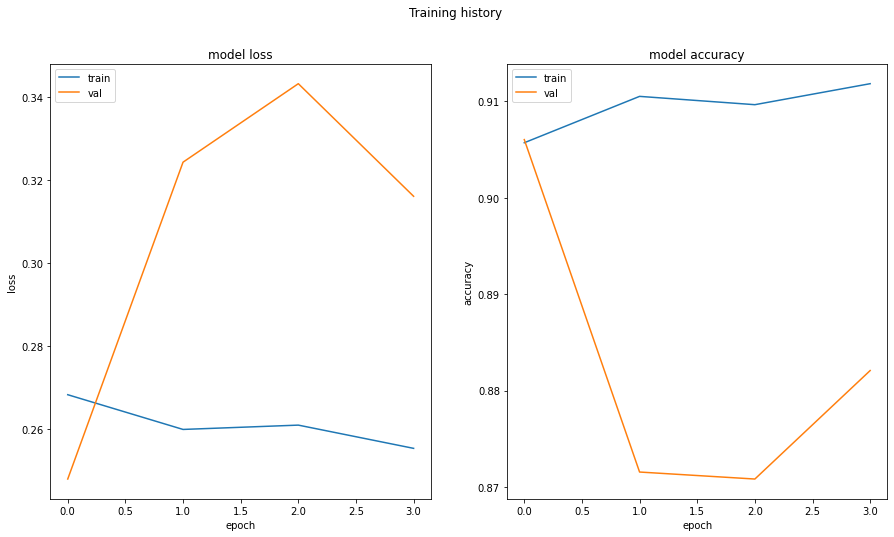

22/22 - 3s - loss: 0.2479 - binary_accuracy: 0.9060 - 3s/epoch - 149ms/step
Fine-tuned model, validation accuracy: 90.60%


In [69]:
# Loads the weights
model.load_weights(checkpoint_path)

# Re-evaluate the model
loss, acc = model.evaluate(val_ds, verbose=2)
print("Restored model, validation accuracy: {:5.2f}%".format(100 * acc))

# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))
print("Number of layers in the decision model: ", len(model.layers) - len(base_model.layers))

for layer in base_model.layers:
  layer.trainable = False

# freeze the base model layers
for layer in base_model.layers[1:3]: # Train the first convolutional layer
  print(layer)
  layer.trainable = True

adam = tf.keras.optimizers.Adam(
    learning_rate=0.000001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False)

model.compile(optimizer=adam, 
              loss='binary_crossentropy',
              metrics=tf.keras.metrics.BinaryAccuracy())

ft_checkpoint_path = "models/transfer-net-finetuned.ckpt"
ft_checkpoint_dir = os.path.dirname(ft_checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=ft_checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True), cp_callback]

fine_tune_epochs = 30
total_epochs =  history.epoch[-1] + fine_tune_epochs

history_fine = model.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch=total_epochs - fine_tune_epochs,
                         validation_data=val_ds,
                         callbacks=callbacks)

plot_training_metrics(history_fine)
# Re-evaluate the model
loss, acc = model.evaluate(val_ds, verbose=2)
print("Fine-tuned model, validation accuracy: {:5.2f}%".format(100 * acc))

## Fine-tune another layer

33/33 - 4s - loss: 0.3077 - binary_accuracy: 0.8977 - 4s/epoch - 116ms/step
Restored model, accuracy: 89.77%
Epoch 12/19
151/151 [==============================] - ETA: 0s - loss: 0.2126 - binary_accuracy: 0.9330
Epoch 00012: saving model to /content/gdrive/My Drive/models/transfer-net-finetuned-2.ckpt
151/151 [==============================] - 36s 217ms/step - loss: 0.2126 - binary_accuracy: 0.9330 - val_loss: 0.2821 - val_binary_accuracy: 0.9095
Epoch 13/19
151/151 [==============================] - ETA: 0s - loss: 0.1741 - binary_accuracy: 0.9517
Epoch 00013: saving model to /content/gdrive/My Drive/models/transfer-net-finetuned-2.ckpt
151/151 [==============================] - 30s 198ms/step - loss: 0.1741 - binary_accuracy: 0.9517 - val_loss: 0.2697 - val_binary_accuracy: 0.9119
Epoch 14/19
151/151 [==============================] - ETA: 0s - loss: 0.1616 - binary_accuracy: 0.9566
Epoch 00014: saving model to /content/gdrive/My Drive/models/transfer-net-finetuned-2.ckpt
151/151 [=

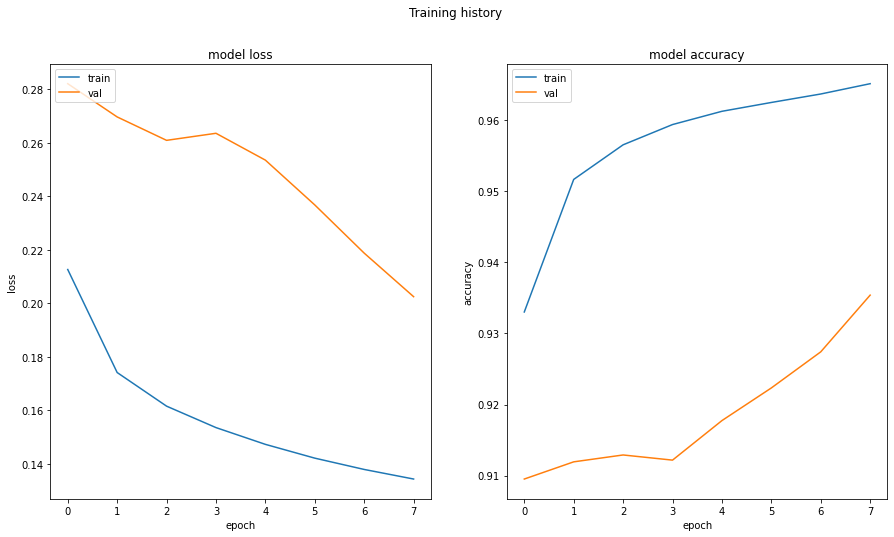

33/33 - 4s - loss: 0.2097 - binary_accuracy: 0.9359 - 4s/epoch - 114ms/step
Fine-tuned model, accuracy: 93.59%


In [ ]:
# Loads the weights from previous checkpoint
model.load_weights(ft_checkpoint_path)

# Re-evaluate the model
loss, acc = model.evaluate(padded_test_ds, verbose=2)
print("Restored model, accuracy: {:5.2f}%".format(100 * acc))

# Re-freeze all base model layers
for layer in base_model.layers:
  layer.trainable = False

# Open up some layers from base model
for layer in base_model.layers[17:21]:
  print(layer)
  layer.trainable = True

# Explicitly define optimizer with low learning rate
adam = tf.keras.optimizers.Adam(
    learning_rate=0.00005, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False)

# Re-compile model
model.compile(optimizer=adam, 
              loss='binary_crossentropy',
              metrics=tf.keras.metrics.BinaryAccuracy())

# Define new path to save weights
ft_checkpoint_path_2 = "/content/gdrive/My Drive/models/transfer-net-finetuned-2.ckpt"
ft_checkpoint_dir_2 = os.path.dirname(ft_checkpoint_path_2)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=ft_checkpoint_path_2,
                                                 save_weights_only=True,
                                                 verbose=1)
# Define callbacks for training
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True), cp_callback]

fine_tune_epochs = 30
total_epochs = history_fine.epoch[-1] + fine_tune_epochs

history_fine_2 = model.fit(padded_train_ds,
                         epochs=total_epochs,
                         initial_epoch=total_epochs - fine_tune_epochs,
                         validation_data=padded_val_ds,
                         callbacks=callbacks)

plot_training_metrics(history_fine)
# Re-evaluate the model
loss, acc = model.evaluate(padded_test_ds, verbose=2)
print("Fine-tuned model, accuracy: {:5.2f}%".format(100 * acc))

33/33 - 4s - loss: 0.2097 - binary_accuracy: 0.9359 - 4s/epoch - 115ms/step
Restored model, accuracy: 93.59%
Epoch 19/48
151/151 [==============================] - ETA: 0s - loss: 0.1847 - binary_accuracy: 0.9441
Epoch 00019: saving model to /content/gdrive/My Drive/models/transfer-net-finetuned-3.ckpt
151/151 [==============================] - 28s 161ms/step - loss: 0.1847 - binary_accuracy: 0.9441 - val_loss: 0.5288 - val_binary_accuracy: 0.8052
Epoch 20/48
151/151 [==============================] - ETA: 0s - loss: 0.1452 - binary_accuracy: 0.9600
Epoch 00020: saving model to /content/gdrive/My Drive/models/transfer-net-finetuned-3.ckpt
151/151 [==============================] - 25s 166ms/step - loss: 0.1452 - binary_accuracy: 0.9600 - val_loss: 0.4669 - val_binary_accuracy: 0.8386
Epoch 21/48
151/151 [==============================] - ETA: 0s - loss: 0.1331 - binary_accuracy: 0.9634
Epoch 00021: saving model to /content/gdrive/My Drive/models/transfer-net-finetuned-3.ckpt
151/151 [=

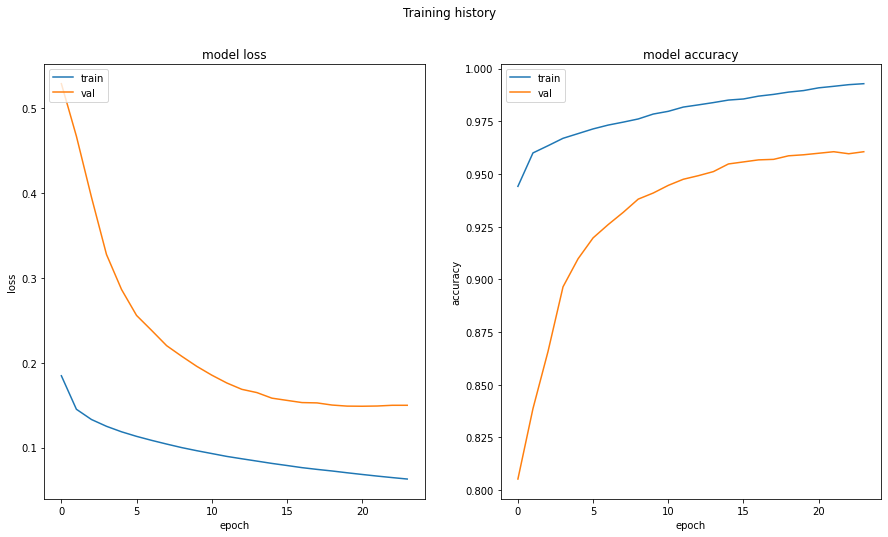

33/33 - 4s - loss: 0.1683 - binary_accuracy: 0.9598 - 4s/epoch - 114ms/step
Fine-tuned model, accuracy: 95.98%


In [ ]:
# Loads the weights from previous checkpoint
model.load_weights(ft_checkpoint_path_2)

# Re-evaluate the model
loss, acc = model.evaluate(padded_test_ds, verbose=2)
print("Restored model, accuracy: {:5.2f}%".format(100 * acc))

# Re-freeze all base model layers
for layer in base_model.layers:
  layer.trainable = False

# Open up some layers from base model
for layer in base_model.layers[70:80]:
  print(layer)
  layer.trainable = True

# Explicitly define optimizer with low learning rate
adam = tf.keras.optimizers.Adam(
    learning_rate=0.00005, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False)

# Re-compile model
model.compile(optimizer=adam, 
              loss='binary_crossentropy',
              metrics=tf.keras.metrics.BinaryAccuracy())

# Define new path to save weights
ft_checkpoint_path_3 = "/content/gdrive/My Drive/models/transfer-net-finetuned-3.ckpt"
ft_checkpoint_dir_3 = os.path.dirname(ft_checkpoint_path_3)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=ft_checkpoint_path_3,
                                                 save_weights_only=True,
                                                 verbose=1)
# Define callbacks for training
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True), cp_callback]

fine_tune_epochs = 30
total_epochs =  history_fine_2.epoch[-1] + history_fine.epoch[-1] + fine_tune_epochs

history_fine_3 = model.fit(padded_train_ds,
                         epochs=total_epochs,
                         initial_epoch=total_epochs - fine_tune_epochs,
                         validation_data=padded_val_ds,
                         callbacks=callbacks)

plot_training_metrics(history_fine)
# Re-evaluate the model
loss, acc = model.evaluate(padded_test_ds, verbose=2)
print("Fine-tuned model, accuracy: {:5.2f}%".format(100 * acc))

# Redo steps 7 and 8 with the following additions to the decision part you built:
### L2 regularization
### Batch Normalization
### Dropout (with small rate) just before softmax
### learning rate scheduler callback


In [ ]:
def scheduler(epoch, lr=0.00005):
  if epoch < 10:
    return lr
  else:
    return lr * tf.math.exp(-0.1)

lr_callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

# Loads the weights from previous checkpoint
model.load_weights(ft_checkpoint_path_3)

# Re-evaluate the model
loss, acc = model.evaluate(padded_test_ds, verbose=2)
print("Restored model, accuracy: {:5.2f}%".format(100 * acc))

# Re-freeze all base model layers
for layer in base_model.layers:
  layer.trainable = False

# Open up some layers from base model
for layer in base_model.layers[70:80]:
  print(layer)
  layer.trainable = True

# Explicitly define optimizer with low learning rate
adam = tf.keras.optimizers.Adam(
    learning_rate=lr_callback, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False)

# Re-compile model
model.compile(optimizer=adam, 
              loss='binary_crossentropy',
              metrics=tf.keras.metrics.BinaryAccuracy())

# Define new path to save weights
ft_checkpoint_path_4 = "/content/gdrive/My Drive/models/transfer-net-finetuned-4.ckpt"
ft_checkpoint_dir_4 = os.path.dirname(ft_checkpoint_path_4)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=ft_checkpoint_path_4,
                                                 save_weights_only=True,
                                                 verbose=1)
# Define callbacks for training
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True), cp_callback]

fine_tune_epochs = 30
total_epochs = history_fine_3.epoch[-1] + history_fine_2.epoch[-1] + history_fine.epoch[-1] + fine_tune_epochs

history_fine_4 = model.fit(padded_train_ds,
                         epochs=total_epochs,
                         initial_epoch=total_epochs - fine_tune_epochs,
                         validation_data=padded_val_ds,
                         callbacks=callbacks)

plot_training_metrics(history_fine)
# Re-evaluate the model
loss, acc = model.evaluate(padded_test_ds, verbose=2)
print("Fine-tuned model, accuracy: {:5.2f}%".format(100 * acc))

33/33 - 5s - loss: 0.1683 - binary_accuracy: 0.9598 - 5s/epoch - 159ms/step
Restored model, accuracy: 95.98%


NameError: ignored